# Setup Empty Pipeline with Screen


In [1]:
# import resources
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume

# Create a screen for our Pipeline
universe = AverageDollarVolume(window_length=60) > 50000

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen=universe)

# Setup Zipline Engine

In [2]:
import helper
from zipline.utils.calendars import get_calendar
from zipline.data import bundles

# Name of bundle
EOD_BUNDLE_NAME = 'quantopian-quandl'

# Load the data bundle
bundle_data = bundles.load(EOD_BUNDLE_NAME)

# Setup the engine to look at the top 500 stocks who have had the highest rolling Average Dollar Volume
# over a 120-day window -- This is arbitrary and we can use this parameter to refine which stocks we
# want in our universe
universe = AverageDollarVolume(window_length=120).top(500) 

# Select the trading calendar that will be used as a reference when slicing the data
trading_calendar = get_calendar('NYSE') 

# Load the bundle we configured in the previous step into the engine
bundle_data = bundles.load(EOD_BUNDLE_NAME)

# Create the engine -- the details of this function are in the utils.py file
engine = helper.build_pipeline_engine(bundle_data, trading_calendar)

# View Pipeline as Graph

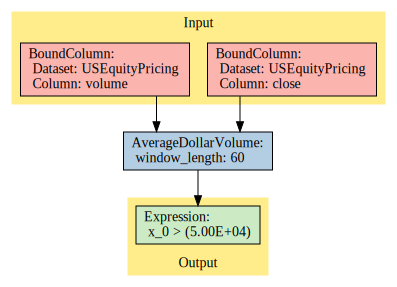

In [3]:
import graphviz

# Render the pipeline as a DAG
pipeline.show_graph()

# Run Pipeline Engine

In [4]:
import pandas as pd

# Set the start and end dates
start_date = pd.Timestamp('2016-01-05', tz = 'utc')
end_date = pd.Timestamp('2016-01-05', tz = 'utc')

# Run our pipeline for the given start and end dates
pipeline_output = engine.run_pipeline(pipeline, start_date, end_date)

# Get Universe Tickers

In [16]:
# Get the values in index level 1 and save them to a list
universe_tickers = pipeline_output.index.get_level_values(1).values.tolist()

# Create Data Portal

In [6]:
from zipline.data.data_portal import DataPortal

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

# View Historical Data

Get the OHLC + V data for a given time period. This data will be split into individual dataframes.

In [7]:
def get_field_data(data_portal, trading_calendar, assets, start_date, end_date, field):
    
    # Set the given start and end dates to Timestamps. The frequency string C is used to
    # indicate that a CustomBusinessDay DateOffset is used
    end_dt = pd.Timestamp(end_date, tz='UTC', freq='C')
    start_dt = pd.Timestamp(start_date, tz='UTC', freq='C')

    # Get the locations of the start and end dates
    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    # return the historical data for the given window
    return data_portal.get_history_window(assets=assets, end_dt=end_dt, bar_count=end_loc - start_loc,
                                          frequency='1d',
                                          field=field,
                                          data_frequency='daily')

# The window of data to obtain
start_date = '2015-01-05'
end_data = '2016-01-05'

# Get the open data
open_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                          start_date, end_date, 'open')

# Get the high data
high_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                              start_date, end_date, 'high')

# Get the low data
low_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                         start_date, end_date, 'low')

# Get the closing data
close_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                              start_date, end_date, 'close') 

# Get the volume data
volume_data = get_field_data(data_portal, trading_calendar, universe_tickers,
                            start_date, end_date, 'volume')

# Combine OHLC dataframes into singular dataframe
Here we combine the four individual dataframes representing OHLC + V data into one historical dataframe.

In [23]:
import numpy as np

#Create dataframe and append blank row
historical_dfs = pd.DataFrame(columns=universe_tickers)
historical_dfs = historical_dfs.append(pd.Series([np.nan]), ignore_index=True)

# Loop through each universe ticker and create a combined dataframe for that ticker
for ticker in universe_tickers:
    # Get individual series representing the OHLCV data
    open_series = open_data[ticker]
    high_series = high_data[ticker]
    low_series = low_data[ticker]
    close_series = close_data[ticker]
    volume_series = volume_data[ticker]
    
    # Combine these series into 1 dataframe
    columns = ['open', 'high', 'low', 'close', 'volume']
    df = pd.concat([open_series,high_series, low_series, close_series, volume_series], axis=1)
    df.columns = columns    
    
    # Save this dataframe to historical_dfs
    historical_dfs[ticker] = pd.Series([df])
    
    
# Change the columns to be more human readable
columns = helper.beautify_tickers(universe_tickers)
historical_dfs.columns = columns

In [24]:
from pypf.instrument import DataframeInstrument
from pypf.chart import PFChart

# Set up dataframe instrument
df = historical_dfs['ABM'][0]
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df['Date'] = df.index.astype(str)
df['Date'] = df['Date'].str.slice(0,10)
df['Volume'] = df['Volume'].astype(int)
dfi = DataframeInstrument('ABM', dataframe=df)

# Create pf chart
chart = PFChart(dfi)
chart.create_chart()
print(chart.chart)


  ABM  (2016-01-05 o: 27.57 h: 27.84 l: 27.55 c: 27.57)
  1.00% box, 3 box reversal, hl method
  signal: sell status: bear confirmed

  33.93|                                                                                |33.93
  33.59|                                          x                                     |33.59
  33.26|                                      x   u d                                   |33.26
  32.93|                                  x   8 d u d                                   |32.93
  32.60|                                  6 7 u d u d                                   |32.60
  32.28|                                  x d u d   o u                                 |32.28
  31.96|                          4   5   u d u     o u d u                             |31.96
  31.65|                      x   u d u d u o       o u d u 9                           |31.65
  31.33|                      x d u d u d u         o u d u d                           |31.33
  31.02|  

In [ ]:
import importlib

importlib.reload(pypf)
importlib.reload(pypf.instrument)

# Create Relative Strength Chart
Use the OHLC data for two stocks to create a RS chart. We will calculate the ratio between the closing price of the two securities on a daily basis, and record this price as all four values of OHLC in the new, combined dataframe. This dataframe can then be used to construct a P&F chart of these ratios, giving us a relative strength chart.

In [35]:
# This function will generate an rs chart for two given securities
def generate_rs_chart(numerator, denominator, historical_dfs):
    ''' 
        This function will generate an RS chart of Numerator/Denominator usingn data from
        historical dfs
        
        @param numerator: (str) Numerator ticker symbol
        @param denominator: (str) Denominator ticker symbol
        @param historical_dfs: (pd.DataFrame) Dataframe where each col is a ticker, and first entry is OHLC data 
                                for that ticker.
    '''
    # Create joint dataframe to hold RS data
    rs_df = pd.DataFrame(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
    
    # Set 'Close' equal to ratio between two close prices on a daily basis
    rs_df['Close'] = historical_dfs[numerator][0]['close'] / historical_dfs[denominator][0]['close']
    
    # Set other columns equal to same ratio (close/close), since this is the only value that matters
    rs_df['High'] = rs_df['Close']
    rs_df['Low'] = rs_df['Close']
    rs_df['Open'] = rs_df['Close']
    rs_df['Volume'] = rs_df['Close']
    
    # Format date for use with DataframeInstrument
    rs_df['Date'] = df.index.astype(str)
    rs_df['Date'] = df['Date'].str.slice(0,10)
    rs_df['Volume'] = df['Volume'].astype(int)
    
    
    # Create a new DataframeInstrument using this new dataframe
    rs_instrument = DataframeInstrument('AAPL_MSFT', dataframe=rs_df)
    
    # Chart the RS data
    # Create pf chart
    chart = PFChart(rs_instrument)
    chart.create_chart()
    print(chart.chart)
    
generate_rs_chart('AAPL', 'MSFT', historical_dfs)


  AAPL_MSFT  (2016-01-05 o: 1.87 h: 1.87 l: 1.87 c: 1.87)
  1.00% box, 3 box reversal, hl method
  signal: sell status: bear confirmed

   3.15|                                                |3.15
   3.11|                  u                             |3.11
   3.08|                  u 4                           |3.08
   3.05|              u   u d                           |3.05
   3.02|          x   u d u d                           |3.02
   2.99|          u 3 u d u o                           |2.99
   2.96|          u d u d   o                           |2.96
   2.93|      x   u d       o                           |2.93
   2.91|      x 2 u         o                           |2.91
   2.88|      x d u         o                           |2.88
   2.85|      x d           o 6                         |2.85
   2.82|      x             o x 7 x                     |2.82
   2.79|      x             o x d u d                   |2.79
   2.76|      x             o x d u d                   |

In [36]:
generate_rs_chart('MSFT', 'AAPL', historical_dfs)


  AAPL_MSFT  (2016-01-05 o: 0.54 h: 0.54 l: 0.54 c: 0.54)
  1.00% box, 3 box reversal, hl method
  signal: buy status: bull confirmed

   0.54|                                                                                |0.54
   0.54|                                                                            1   |<< 0.54
   0.53|                                                                            x   |0.53
   0.52|                                                                            x   |0.52
   0.52|                                                                            x   |0.52
   0.51|                                                                            x   |0.51
   0.51|                                                                            x   |0.51
   0.50|                                                                            x   |0.50
   0.50|                                                                            x   |0.50
   0.49|       